<a href="https://colab.research.google.com/github/nasimnou/basic_vqa/blob/master/one_Gan%2Btorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [0]:
import torch 
import numpy as np 
import torchvision 
import torch.nn as nn 
torch.__version__
import time
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary
import copy 
import random
import matplotlib.pyplot as plt
from torchvision import transforms ,models

from torch.autograd import Variable



torch.cuda.get_device_name
print(torch.cuda.get_device_properties("cuda"))
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [0]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# params

In [0]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
batch_size=30
z_dim = 100

# Dataset

In [0]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset= torchvision.datasets.MNIST("./MNIST", train=True, transform=transform, download=True)
test_dataset= torchvision.datasets.MNIST("./MNIST", train=False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 28087788.53it/s]                            


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


32768it [00:00, 442238.73it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144822.28it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


1654784it [00:00, 7175907.76it/s]                            
8192it [00:00, 185358.60it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw
Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


In [0]:
len(train_dataset)

60000

In [0]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,  shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [0]:
lo=[]
for data,label in train_loader:
 lo.append(label)
print (len(lo[0]))
print (lo[0])


30
tensor([9, 9, 7, 4, 6, 2, 5, 8, 4, 5, 2, 3, 0, 4, 0, 9, 5, 7, 8, 2, 4, 5, 6, 8,
        6, 4, 4, 3, 6, 7])


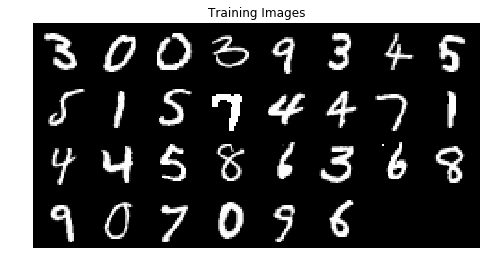

In [0]:
import torchvision.utils as vutils
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# gen_one

In [0]:
class generator_A(nn.Module):

    def __init__(self):
   
        super(generator_A, self).__init__()
  
       
        self.fc1 = nn.Linear(z_dim, 7 * 7 * 256)
        ###################reshape in forward 

        # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
        self.conv1 = nn.ConvTranspose2d(256, 128,3,stride=2,padding=1,output_padding=1)
         #nn.ConvTranspose2d(  )
        # Batch normalization
        self.BN1 = nn.BatchNorm2d(128)

        ###################Leaky ReLU

        # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
        self.conv2 = nn.ConvTranspose2d(128,64, 3,stride=1, padding=1,output_padding=0)
         # Batch normalization
        self.BN2 = nn.BatchNorm2d(64)

        ###################Leaky ReLU

        # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
        self.conv3 = nn.ConvTranspose2d(64,1, 3,stride=2,padding=1,output_padding=1)

        ###################TAN activation 

    def forward(self,x):
      y=self.fc1(x)
      # print(y.shape)
      y = y.view(-1,256,7,7)
      # print(y.shape)
      y = F.leaky_relu(self.BN1(self.conv1(y)),negative_slope=0.2)
      # print(y.shape)
      y = F.leaky_relu(self.BN2(self.conv2(y)),negative_slope=0.2)
      # print(y.shape)
      y = F.tanh(self.conv3(y))
      # print (y.shape)
      
      return y




In [0]:
img_rand=torch.rand(65,z_dim).to(device)
g_model=generator_A().to(device)
out=g_model(img_rand)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(out.detach().to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# discriminator

In [0]:
class discriminator(nn.Module):

    def __init__(self):
      super(discriminator, self).__init__()
      
      #Convolutional layer, from 28x28x1 into 14x14x32 tensor
      self.conv1 = nn.Conv2d(1, 32,3,stride=2, padding=1)
      ################### Leaky ReLU

      # Convolutional layer, from 14x14x32 into 7x7x64 tensor
      self.conv2 = nn.Conv2d(32, 64,3,stride=2, padding=1)

      # Batch normalization
      self.BN1 = nn.BatchNorm2d(64)

      ################### Leaky ReLU

      # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
      self.conv3 = nn.Conv2d(64, 128,3,stride=2, padding=0)

      # Batch normalization
      self.BN2 = nn.BatchNorm2d(128)

      ################### Leaky ReLU

      ###################Reshape

      # Dense layer,from 128*3*3 to channel 1
      self.fc1 = nn.Linear(1152,1)



        
    def forward(self,x):
      y = F.leaky_relu(self.conv1(x),negative_slope=0.2)
      # print(y.shape)


      y = F.leaky_relu(self.BN1(self.conv2(y)),negative_slope=0.2)
      # print("y1",y.shape)

      y = F.leaky_relu(self.BN2(self.conv3(y)),negative_slope=0.2)
      # print("y2",y.shape)

      y = y.view(y.size()[0],-1)
      # print("y3",y.shape)

      y= F.sigmoid(self.fc1(y))
      # print("y4",y.shape)

      return y



  

In [0]:
# img_rand=torch.rand(10,1,28,28).to(device)
d_model=discriminator().to(device)
# out=d_model(img_rand)

# Config 

In [0]:
criterion = torch.nn.BCELoss()
D_optimizer = optim.Adam(d_model.parameters(),lr=0.0002)
G_optimizer = optim.Adam(g_model.parameters(),lr=0.0002)

# Train

In [0]:
def sample_images(iteration):
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  noise=torch.Tensor(np.random.uniform(low=-1.0, high=1.0,size=(30,100))).to(device)
  plt.imshow(np.transpose(vutils.make_grid( g_model(Variable(noise)).detach().to(device)[:30], padding=2, normalize=True).cpu(),(1,2,0)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 G_loss 5.114178657531738 D_loss 0.010823031887412071
epoch 1 G_loss 6.49806022644043 D_loss 0.06092892959713936
epoch 2 G_loss 3.596195697784424 D_loss 0.14237534999847412
epoch 3 G_loss 4.693603992462158 D_loss 0.4195006489753723
epoch 4 G_loss 5.170291423797607 D_loss 0.11839275062084198
epoch 5 G_loss 5.911862373352051 D_loss 0.10827995836734772
epoch 6 G_loss 2.4224226474761963 D_loss 0.19255545735359192
epoch 7 G_loss 5.440006732940674 D_loss 0.016870275139808655
epoch 8 G_loss 4.748167991638184 D_loss 0.03867818042635918
epoch 9 G_loss 3.7581093311309814 D_loss 0.18709492683410645
epoch 10 G_loss 2.780707836151123 D_loss 0.5075532793998718
epoch 11 G_loss 5.56514310836792 D_loss 0.03033231385052204
epoch 12 G_loss 2.940638780593872 D_loss 0.07547011971473694
epoch 13 G_loss 4.859579563140869 D_loss 0.04885127395391464
epoch 14 G_loss 4.187050819396973 D_loss 0.8736706376075745
epoch 15 G_loss 3.7900917530059814 D_loss 0.11479335278272629
epoch 16 G_loss 2.9137730598449707

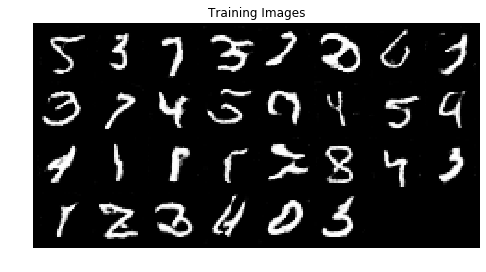

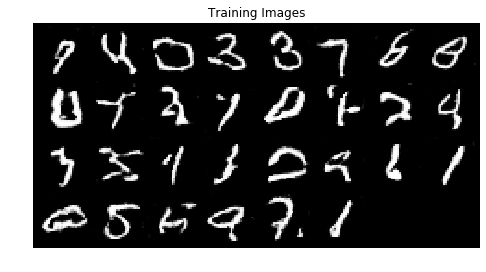

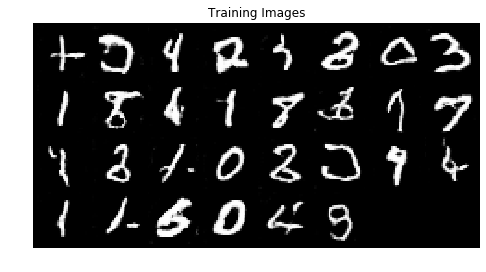

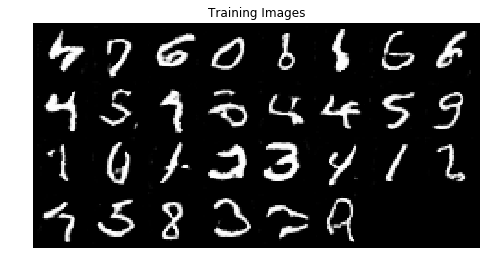

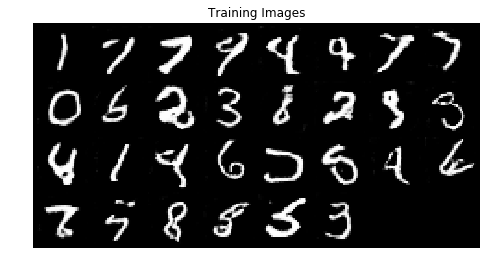

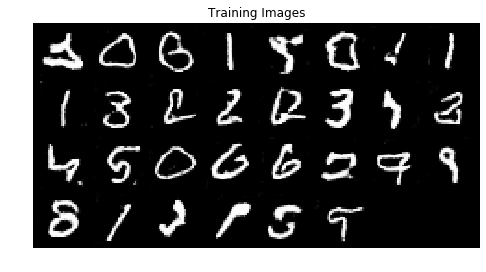

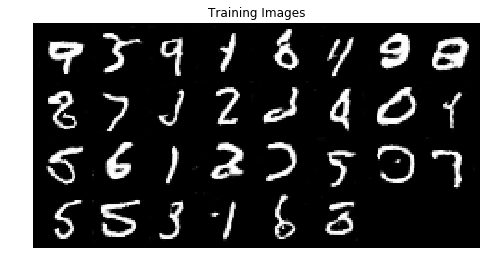

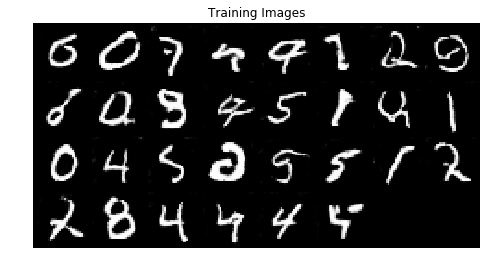

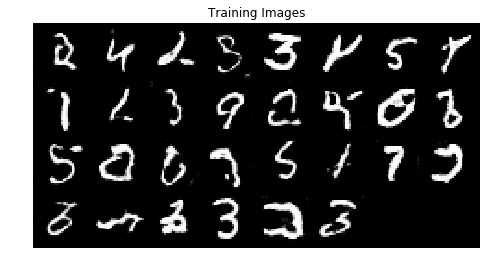

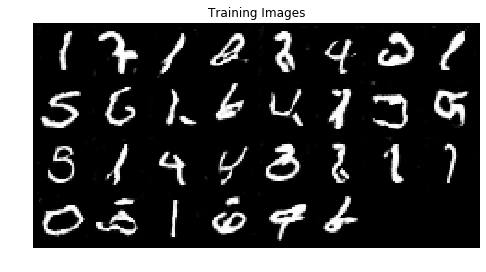

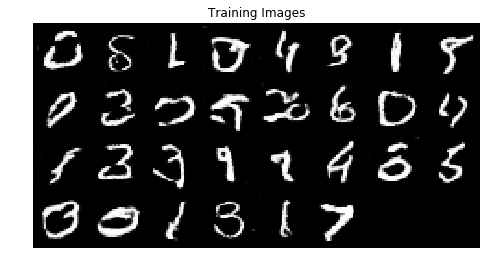

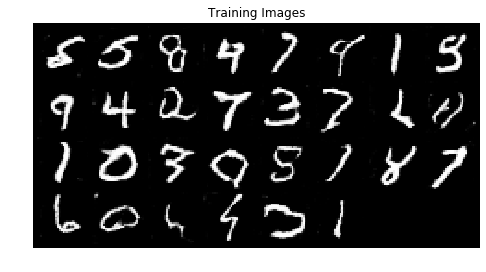

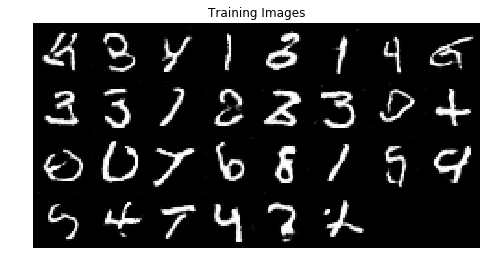

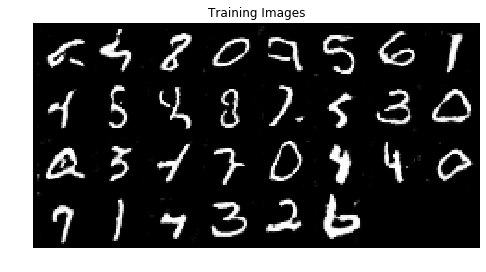

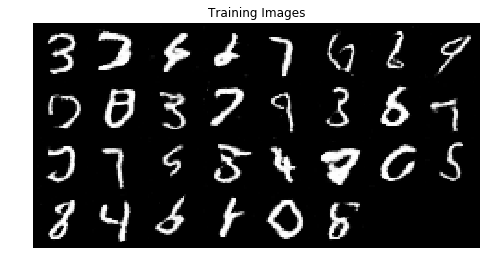

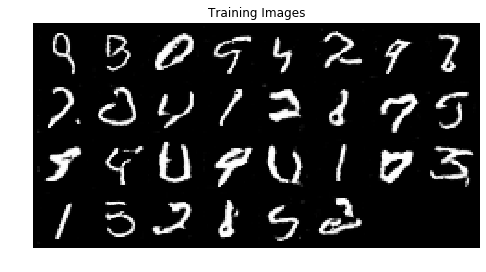

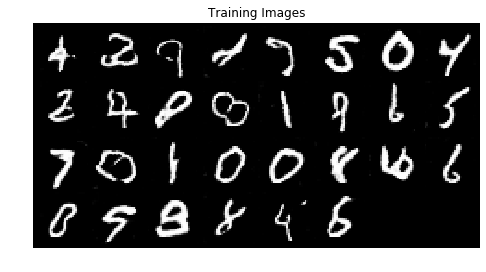

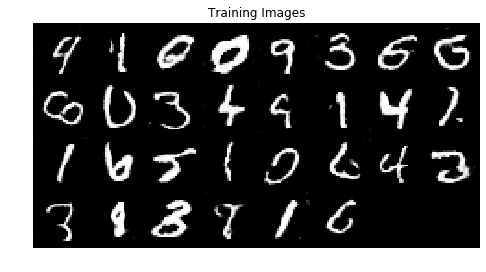

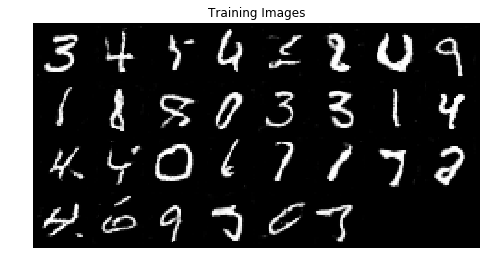

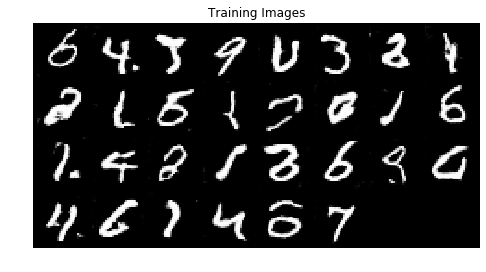

In [0]:
n_update_dis=1
n_update_gen=1
print_every=10
update_max=None

for epoch in range(20):
  D_running_loss = 0.0
  G_running_loss = 0.0
  real_label=torch.ones((batch_size, 1))
  real_label=real_label.to(device)
  fake_label=torch.zeros((batch_size, 1))
  fake_label=fake_label.to(device)
 
  for i, (data,_) in enumerate(train_loader, 0):
    # Select a random batch of real images
    real_imgs=data.to(device)
    # Generate a batch of fake images
    noise=torch.Tensor(np.random.uniform(low=-1.0, high=1.0,size=(batch_size,z_dim))).to(device)
    noise[:,:30]=0
    noise[:,70:]=0
    gen_imgs=g_model(noise)


    # Discriminator loss for True image 

    ## forward + backprop + loss :for real images
    d_model.zero_grad()
    real_v = d_model(real_imgs)
    D_loss_real = criterion(real_v, real_label)
    D_loss_real.backward()

    ## forward + backprop + loss :for fake images
    fake_v = d_model(gen_imgs.detach()) ###########really important for detach 
    D_loss_fake = criterion(fake_v, fake_label)
    D_loss_fake.backward()

    #Total D_loss
    D_loss=D_loss_real + D_loss_fake
    ## update model params
    D_optimizer.step()


    # ---------------------
    #  Train the Generator
    # ---------------------
 

    # Generator loss

    
  ## forward + backprop + loss :for real images
    True_label = torch.ones((batch_size, 1)).to(device)

    g_model.zero_grad()
    gen_v=d_model(gen_imgs)
    G_loss = criterion(gen_v, True_label)
    G_loss.backward()
    G_optimizer.step()


  print ("epoch",epoch,"G_loss",G_loss.item(),"D_loss",D_loss.item())
  sample_images(epoch)





In [0]:
img_rand=torch.rand(1,100).to(device)

out=g_model(img_rand)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


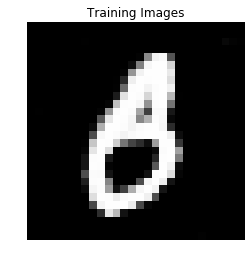

In [0]:

plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(out.detach().to(device)[:1], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
a=torch.Tensor(np.random.uniform(low=-1.0, high=1.0,size=(batch_size,z_dim)))
a.shape

torch.Size([30, 100])

In [0]:
a[:,:30]=0
a[:,70:]=0